In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import string

from tqdm.notebook import tqdm_notebook

import spacy
import en_core_web_sm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF

# Load data

In [6]:
df = pd.read_csv('data/ciphix.csv', header=None, names=['text'])

In [7]:
df

,text
0,@115712 I understand. I would like to assist y...
1,@sprintcare and how do you propose we do that
2,@sprintcare I have sent several private messag...
3,@115712 Please send us a Private Message so th...
4,@sprintcare I did.
...,...
2811769,"@823869 Hey, we'd be happy to look into this f..."
2811770,@115714 wtf!? I’ve been having really shitty s...
2811771,@143549 @sprintcare You have to go to https://...
2811772,"@823870 Sounds delicious, Sarah! 😋 https://t.c..."


# Look around

In [8]:
df.isna().sum()

text    0
dtype: int64

In [9]:
df["wordcount"] = df["text"].str.split().str.len()

<Axes: >

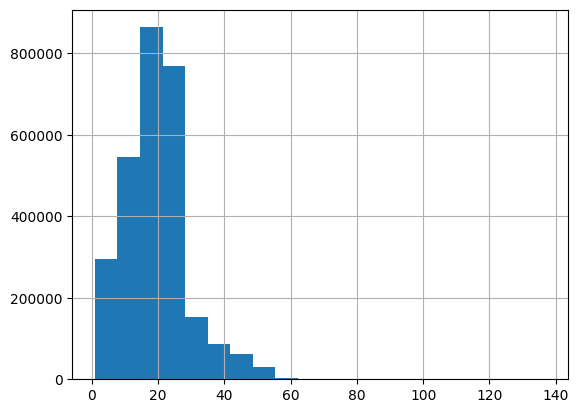

In [10]:
df['wordcount'].hist(bins=20)

In [11]:
df

,text,wordcount
0,@115712 I understand. I would like to assist y...,23
1,@sprintcare and how do you propose we do that,9
2,@sprintcare I have sent several private messag...,14
3,@115712 Please send us a Private Message so th...,23
4,@sprintcare I did.,3
...,...,...
2811769,"@823869 Hey, we'd be happy to look into this f...",25
2811770,@115714 wtf!? I’ve been having really shitty s...,15
2811771,@143549 @sprintcare You have to go to https://...,30
2811772,"@823870 Sounds delicious, Sarah! 😋 https://t.c...",6


### Conclusions
Looking around I noticed:
- all messages start with some kind of username handle
- some have multiple username handles
- some end with a different tag ^ followed by user acronym
- different languages
- smileys
- URLS

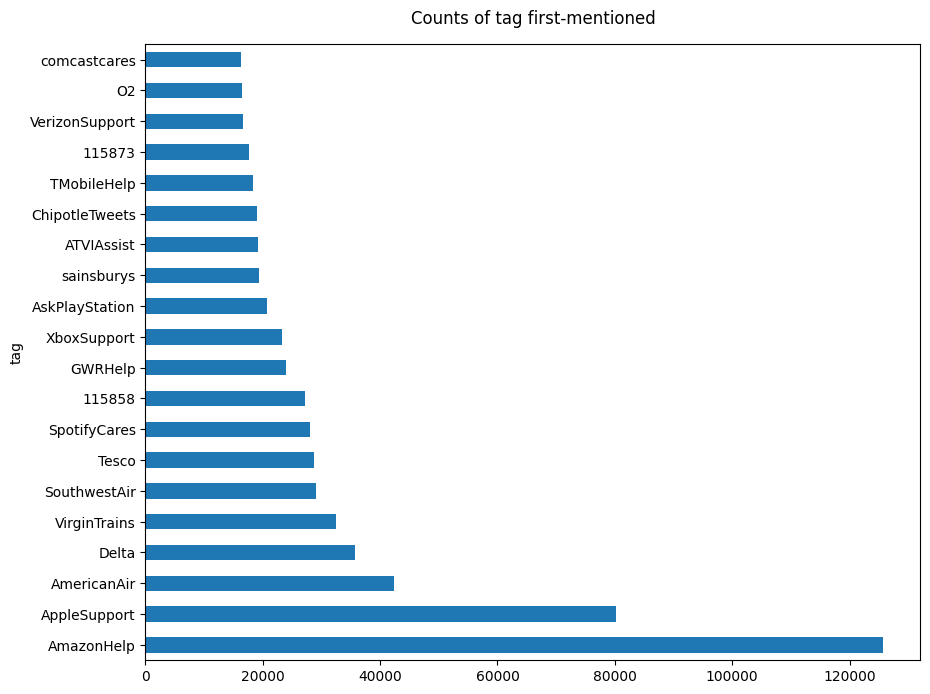

In [12]:
#Lets check the counts of the first tag mentioned
split = df['text'].str.extract(r'(@([a-zA-Z\d]+)([^\S\r\n]))(.*)')
split['text'] = split[3]
split['tag'] = split[1]
split = split[['tag','text']]
split = split.dropna(subset='text')
split['tag'].value_counts()[:20].plot(kind='barh', figsize=(10, 8))
plt.title("Counts of tag first-mentioned", y=1.02);

# Clean

In [13]:
#Remove all @ tags
def remove_ats(text):
    at_pattern = re.compile('@[a-zA-Z\d_]+')
    return at_pattern.sub(r'', text)

#Remove all employee tags
#Tags occur at the end of the line with capital letters and prefix '-' or '^'
def remove_tag(text):
    at_pattern = re.compile('[\^\-][A-Z\d]+$')
    return at_pattern.sub(r'', text)

#Remove URLS
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

#Remove smileys
def remove_emoji(text):   
    emoji_pattern = re.compile("["
                            "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "\U0001F300-\U0001F5FF"  # symbols & pictographs
                            "\U0001F600-\U0001F64F"  # emoticons
                            "\U0001F680-\U0001F6FF"  # transport & map symbols
                            "\U0001F700-\U0001F77F"  # alchemical symbols
                            "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                            "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                            "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                            "\U0001FA00-\U0001FA6F"  # Chess Symbols
                            "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                            "\U00002702-\U000027B0"  # Dingbats
                            "\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#Remove newlines.
def remove_specialchars(text):
    char_pattern = re.compile('[\n]')
    return char_pattern.sub(r'', text)

#Remove only non-letters


In [14]:
df['clean_text'] = df['text'].apply(remove_ats) \
                                .apply(remove_urls) \
                                .apply(remove_tag) \
                                .apply(remove_emoji) \
                                .apply(remove_specialchars)

In [15]:
df.head(n=25) 

,text,wordcount,clean_text
0,@115712 I understand. I would like to assist y...,23,I understand. I would like to assist you. We ...
1,@sprintcare and how do you propose we do that,9,and how do you propose we do that
2,@sprintcare I have sent several private messag...,14,I have sent several private messages and no o...
3,@115712 Please send us a Private Message so th...,23,Please send us a Private Message so that we c...
4,@sprintcare I did.,3,I did.
5,@115712 Can you please send us a private messa...,19,"Can you please send us a private message, so ..."
6,@sprintcare is the worst customer service,6,is the worst customer service
7,@115713 This is saddening to hear. Please shoo...,21,This is saddening to hear. Please shoot us a ...
8,@sprintcare You gonna magically change your co...,16,You gonna magically change your connectivity ...
9,@115713 We understand your concerns and we'd l...,25,We understand your concerns and we'd like for...


### Wrapup and count again

(2811774, 3)


<Axes: >

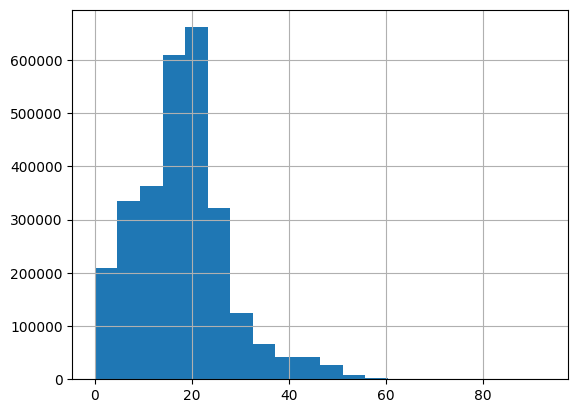

In [16]:
df = df.dropna(subset='clean_text')
print(df.shape)
df["wordcount"] = df["clean_text"].str.split().str.len()
df['wordcount'].hist(bins=20)

### Inspect special cases

In [17]:
pd.set_option('display.max_rows', 50)
small = df.loc[df["wordcount"]<2,:].head(n=20)
small

,text,wordcount,clean_text
49,@VerizonSupport Yep,1,Yep
130,@ATVIAssist Thanks,1,Thanks
168,@AdobeCare ok,1,ok
182,@AmazonHelp ありがとうございます。\n今、電話で主人が対応していただいてます。,0,
183,@AmazonHelp 電話で対応してもらいましたが改良されませんでした。\n保証期間も過ぎ...,0,
184,@115770 カスタマーサービスにてお問い合わせ済みとのことで、お手数をおかけいたしました...,1,ET
185,@AmazonHelp こちらこそありがとうございました。,0,
186,@115770 恐れ入ります。至らない点も多々あるかとは存じますが、今後ともどうぞよろしくお...,1,ET
187,amazonのfireTVstickが見れない😢,1,amazonfireTVstick
235,amazonプライムビデオ、再生エラーが多いです,1,amazon


In [18]:
#Remove remaining text not containing letters
df = df[~df['clean_text'].str.fullmatch('^[\s\d]+$')] 

In [19]:
df.loc[df["wordcount"]<2,:].head(n=20)

,text,wordcount,clean_text
49,@VerizonSupport Yep,1,Yep
130,@ATVIAssist Thanks,1,Thanks
168,@AdobeCare ok,1,ok
184,@115770 カスタマーサービスにてお問い合わせ済みとのことで、お手数をおかけいたしました...,1,ET
186,@115770 恐れ入ります。至らない点も多々あるかとは存じますが、今後ともどうぞよろしくお...,1,ET
187,amazonのfireTVstickが見れない😢,1,amazonfireTVstick
235,amazonプライムビデオ、再生エラーが多いです,1,amazon
268,@115797 H,1,H
300,@McDonalds Treat!,1,Treat!
497,@115885 2/2 https://t.co/6iDGBJAc2m,1,2/2


In [20]:
#Largest wordcounts seem only a few cases that I accept for now
df.loc[df["wordcount"]>65,:]

,text,wordcount,clean_text
79293,@116230 I HATE YOU. I HATE YOU. I HATE YOU. I ...,66,I HATE YOU. I HATE YOU. I HATE YOU. I HATE YO...
741778,@AppleSupport NO NO NO NO NO NO NO NO NO NO NO...,93,NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO ...
1619605,I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I...,68,I I I I I I I I I I I I I I I I I I I I I I I ...
1764193,"@idea_cares रात भर मे बीस बार ये मैसेज आते है,...",69,"रात भर मे बीस बार ये मैसेज आते है, जब कि रात ..."
1956083,@AppleSupport \n\nI️ I️ I️ I️ I️ I️ I️ I️ I️ I...,66,I I I I I I I I I I I I I I I I I I I I I I I...
1958113,I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I...,68,I I I I I I I I I I I I I I I I I I I I I I I ...
1961141,I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I...,68,I I I I I I I I I I I I I I I I I I I I I I I ...
1972751,.@116333 I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I...,68,. I I I I I I I I I I I I I I I I I I I I I I ...
1991064,I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I...,69,I I I I I I I I I I I I I I I I I I I I I I I ...
2048019,I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I...,68,I I I I I I I I I I I I I I I I I I I I I I I ...


# Preprocessing

In [105]:
# We only need tokenizer, pos tagging and lemmatization
nlp = en_core_web_sm.load(disable=["parser", "ner", "textcat"])


In [106]:
"""
I select for Nouns, proper Nouns and Verbs since those will the most useful in a topic detection
in customer service setting with the end goal of automation.
"""

def preprocess(texts):
    docs = nlp.pipe(texts, n_process=8)
    output = []
    for doc in docs:
        pos_sel = " ".join(token.lemma_ for token in doc if (token.pos_ in ['PROPN','NOUN','VERB'] and not token.is_stop))
        output.append(pos_sel)
    return(output)


In [107]:
tqdm_notebook.pandas()
df['processed_text'] = preprocess(df['clean_text'])
# test = preprocess(df.loc[:20,'clean_text'])


In [112]:
pd.set_option('display.max_colwidth', 100)

df

,text,wordcount,clean_text,processed_text
0,@115712 I understand. I would like to assist you. We would need to get you into a private secure...,22,I understand. I would like to assist you. We would need to get you into a private secured link ...,understand like assist need secure link assist
1,@sprintcare and how do you propose we do that,8,and how do you propose we do that,propose
2,@sprintcare I have sent several private messages and no one is responding as usual,13,I have sent several private messages and no one is responding as usual,send message respond
3,@115712 Please send us a Private Message so that we can further assist you. Just click ‘Message’...,22,Please send us a Private Message so that we can further assist you. Just click ‘Message’ at the...,send message assist click message profile
4,@sprintcare I did.,2,I did.,
...,...,...,...,...
2811769,"@823869 Hey, we'd be happy to look into this for you. Please send us a Direct Message, so that w...",23,"Hey, we'd be happy to look into this for you. Please send us a Direct Message, so that we can f...",look send Direct Message assist
2811770,@115714 wtf!? I’ve been having really shitty service all day !! Get your shit together!,14,wtf!? I’ve been having really shitty service all day !! Get your shit together!,wtf have service day shit
2811771,@143549 @sprintcare You have to go to https://t.co/v2tMHeTL7Q and ask them to add the Hulu servi...,26,You have to go to and ask them to add the Hulu service to your account. After you get the tex...,ask add Hulu service account text
2811772,"@823870 Sounds delicious, Sarah! 😋 https://t.co/7uQPwyH1B6",3,"Sounds delicious, Sarah!",sound Sarah


In [121]:
df.to_csv('data/ciphix_pre_processed')

# NLP

In [114]:


# Creating a vectorizer
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')

data_vectorized = vectorizer.fit_transform(df["processed_text"])


In [122]:
topic_count = 10

In [124]:
nmf = NMF(n_components=topic_count)
data_nmf = nmf.fit_transform(data_vectorized) 

In [127]:

for idx, topic in enumerate(nmf.components_):
    print("Topic %d:" % (idx))
    print([(vectorizer.get_feature_names_out()[i], topic[i])
                    for i in topic.argsort()[:-topic_count - 1:-1]]) 

Topic 0:
[('help', 38.87144944732882), ('need', 4.111272707379024), ('like', 2.86040979996582), ('want', 1.6659941523390782), ('try', 1.5621256180703504), ('reach', 1.4884627697637547), ('support', 1.4175738695894007), ('team', 1.2731871473191199), ('contact', 1.100427019871391), ('love', 0.9989438313203926)]
Topic 1:
[('thank', 20.811726705721), ('reach', 2.08650951254418), ('team', 1.0252932319424581), ('feedback', 0.9724039144508685), ('store', 0.9522674456151687), ('share', 0.728649670032469), ('check', 0.617919573384388), ('reply', 0.5811754191458083), ('pass', 0.572164780164214), ('contact', 0.5670108718440697)]
Topic 2:
[('number', 15.612037985484406), ('phone', 11.613158741747515), ('account', 2.3440106431327155), ('address', 1.6552123303064061), ('assist', 1.5253755566733131), ('contact', 1.5045591812773211), ('tracking', 1.2551588870609813), ('provide', 1.120906370874304), ('link', 0.9389588040599083), ('check', 0.9242835151945294)]
Topic 3:
[('let', 17.787380308006817), ('kn